In [1]:
import sys
sys.path.insert(0,"..")
sys.path.insert(0, "../mwcnn/")
%matplotlib inline
import matplotlib.pyplot as plt

import torch, gc
from torch.utils.data import SubsetRandomSampler
import torch.optim as optim


from unet.model import UNet
from unet.unet_trainer import *

from gan.discriminator import Discriminator
from gan.gan_training import GANTrainer

from mwcnn import MWCNN
from training import MWCNNTrainer

from src.loss_functions import VGGPerceptualLoss
from src.dataset import ImageDataset
from src.utils import get_indices

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Dataset part used for testing
VALIDATION_SPLIT = 0.15
# Batch size for training. Limited by GPU memory
BATCH_SIZE = 2
# Full Dataset path
TEST_DATASETS = ['val']
TRAIN_DATASETS = ['train']
ROOTDIR = '../data/'

# Training Epochs
EPOCHS = 100

IMAGESIZE = 256

gc.collect()
torch.cuda.empty_cache()

/home/jurri/miniconda3/lib/python3.11/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/home/jurri/miniconda3/lib/python3.11/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may hav

In [2]:
train_image_dataset = ImageDataset(ROOTDIR, TRAIN_DATASETS, normalize="minmax", image_size=IMAGESIZE)
train_indices, validation_indices = get_indices(len(train_image_dataset), train_image_dataset.root_dir, VALIDATION_SPLIT, new=True)
train_sampler, validation_sampler = SubsetRandomSampler(train_indices), SubsetRandomSampler(validation_indices)

trainloader = torch.utils.data.DataLoader(train_image_dataset, BATCH_SIZE, sampler=train_sampler)
validationloader = torch.utils.data.DataLoader(train_image_dataset, BATCH_SIZE, sampler=validation_sampler)

test_image_dataset = ImageDataset(ROOTDIR, TEST_DATASETS, normalize="minmax", image_size=IMAGESIZE)
testloader = torch.utils.data.DataLoader(test_image_dataset, 1)

/home/jurri/miniconda3/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `transforms.Compose([transforms.ToImageTensor(), transforms.ConvertImageDtype()])`.
  warnings.warn(


## Pretrain UNET
First pretrain a UNET and MWCNN, afterwards, this can be used in the GAN set-up

In [3]:
# Filters used in UNet Model
filter_num = [16,32,64,128,256]
MODEL_NAME = f"models/UNet-{filter_num}.pt"
unet_model = UNet(filter_num).to(device)
# Start training.
unet_trainer = Unet_trainer(unet_model,device=device, learning_rate=0.002)
train_loss_record, validation_loss = unet_trainer.train(EPOCHS,trainloader,validationloader)
torch.save(unet_model.state_dict(), MODEL_NAME)

Starting Training Process
Epoch: 001,  Train Loss:0.0366654,  Validation Loss:0.0266687,  Time training: 0h0m6s
Epoch: 002,  Train Loss:0.0323942,  Validation Loss:0.0363971,  Time training: 0h0m11s
Epoch: 003,  Train Loss:0.0344807,  Validation Loss:0.0309291,  Time training: 0h0m15s
Epoch: 004,  Train Loss:0.0312386,  Validation Loss:0.0354951,  Time training: 0h0m20s
Epoch: 005,  Train Loss:0.0303639,  Validation Loss:0.0246648,  Time training: 0h0m24s
Epoch: 006,  Train Loss:0.0266664,  Validation Loss:0.0267618,  Time training: 0h0m29s
Epoch: 007,  Train Loss:0.0271431,  Validation Loss:0.0210511,  Time training: 0h0m33s
Epoch: 008,  Train Loss:0.0253653,  Validation Loss:0.0277584,  Time training: 0h0m38s
Epoch: 009,  Train Loss:0.0257977,  Validation Loss:0.0281557,  Time training: 0h0m42s
Epoch: 010,  Train Loss:0.0250265,  Validation Loss:0.0228657,  Time training: 0h0m47s
Epoch: 011,  Train Loss:0.0243427,  Validation Loss:0.0226667,  Time training: 0h0m51s
Epoch: 012,  Train

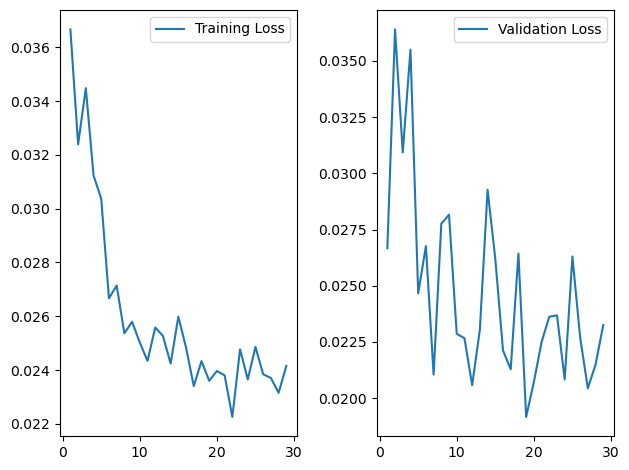

In [4]:
fig, ax = plt.subplots(nrows=1,ncols=2)
num_epochs = len(train_loss_record)
ax[0].plot(range(1, num_epochs + 1), train_loss_record, label='Training Loss')
ax[0].legend()
ax[1].plot(range(1, num_epochs + 1), validation_loss, label='Validation Loss')
ax[1].legend()
plt.tight_layout()

## Train GAN with UNET


In [5]:
unet_discriminator = Discriminator(n_feats=32, patch_size=IMAGESIZE).to(device)
unet_gan_trainer = GANTrainer(unet_model, unet_discriminator, device=device, learning_rate=1e-3)

unet_gan_loss_record, unet_gan_validation_loss_record = unet_gan_trainer.train(EPOCHS, trainloader, validationloader)
torch.save(unet_model.state_dict(), f"models/GAN_UNet-{filter_num}.pt")

/home/jurri/miniconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jurri/miniconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Starting Training Process
Epoch: 001,  Train Loss:0.4606907,  Validation Loss:0.4185348,  Time training: 0h0m38s
Epoch: 002,  Train Loss:0.4436196,  Validation Loss:0.4882853,  Time training: 0h1m16s
Epoch: 003,  Train Loss:0.4589952,  Validation Loss:0.4468812,  Time training: 0h1m55s
Epoch: 004,  Train Loss:0.4563645,  Validation Loss:0.4519047,  Time training: 0h2m33s
Epoch: 005,  Train Loss:0.4250713,  Validation Loss:0.4192480,  Time training: 0h3m12s
Epoch: 006,  Train Loss:0.4508076,  Validation Loss:0.3801620,  Time training: 0h3m50s
Epoch: 007,  Train Loss:0.4367332,  Validation Loss:0.4525065,  Time training: 0h4m29s
Epoch 00008: reducing learning rate of group 0 to 8.5000e-04.
Epoch: 008,  Train Loss:0.4407128,  Validation Loss:0.3733107,  Time training: 0h5m7s
Epoch: 009,  Train Loss:0.4412566,  Validation Loss:0.4618707,  Time training: 0h5m46s
Epoch: 010,  Train Loss:0.4177070,  Validation Loss:0.4341131,  Time training: 0h6m24s
Epoch: 011,  Train Loss:0.4460360,  Validat

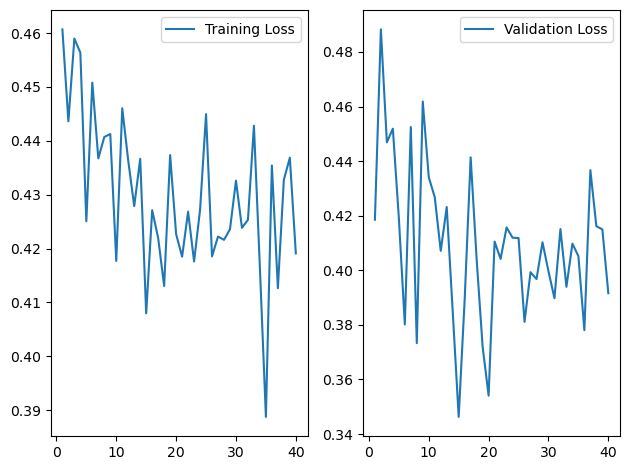

In [8]:
fig, ax = plt.subplots(nrows=1,ncols=2)
num_epochs = len(unet_gan_loss_record)
ax[0].plot(range(1, num_epochs + 1), unet_gan_loss_record, label='Training Loss')
ax[0].legend()
ax[1].plot(range(1, num_epochs + 1), unet_gan_validation_loss_record, label='Validation Loss')
ax[1].legend()
plt.tight_layout()

## Now do the same for MWCNN model

In [3]:
N_FEATS=32
MWCNN_model = MWCNN(n_feats=N_FEATS, n_colors=1, batch_normalize=True).to(device)
# Initialize trainer
MWCNN_trainer = MWCNNTrainer(
    MWCNN_model, learning_rate=1e-3,
    local_criterion=torch.nn.L1Loss(), global_criterion=None, 
    scale=0, device=device)
# Do training
train_loss_record, validation_loss = MWCNN_trainer.train(EPOCHS,trainloader, validationloader)
torch.save(MWCNN_model.state_dict(), f"models/none_mwcnn_feats_{N_FEATS}.pt")

Starting Training Process
Epoch: 001,  Train Loss:0.0435546,  Validation Loss:0.0662104,  Time training: 0h0m16s
Epoch: 002,  Train Loss:0.0328500,  Validation Loss:0.1896597,  Time training: 0h0m30s
Epoch: 003,  Train Loss:0.0293202,  Validation Loss:0.0254063,  Time training: 0h0m44s
Epoch: 004,  Train Loss:0.0254651,  Validation Loss:0.0185463,  Time training: 0h0m58s
Epoch: 005,  Train Loss:0.0243771,  Validation Loss:0.0479464,  Time training: 0h1m12s
Epoch: 006,  Train Loss:0.0232670,  Validation Loss:0.0914962,  Time training: 0h1m25s
Epoch: 007,  Train Loss:0.0237162,  Validation Loss:0.0783228,  Time training: 0h1m39s
Epoch: 008,  Train Loss:0.0229921,  Validation Loss:0.0260498,  Time training: 0h1m53s
Epoch: 009,  Train Loss:0.0224563,  Validation Loss:0.0239650,  Time training: 0h2m7s
Epoch: 010,  Train Loss:0.0207507,  Validation Loss:0.0372725,  Time training: 0h2m21s
Epoch: 011,  Train Loss:0.0223925,  Validation Loss:0.0294818,  Time training: 0h2m35s
Epoch: 012,  Train

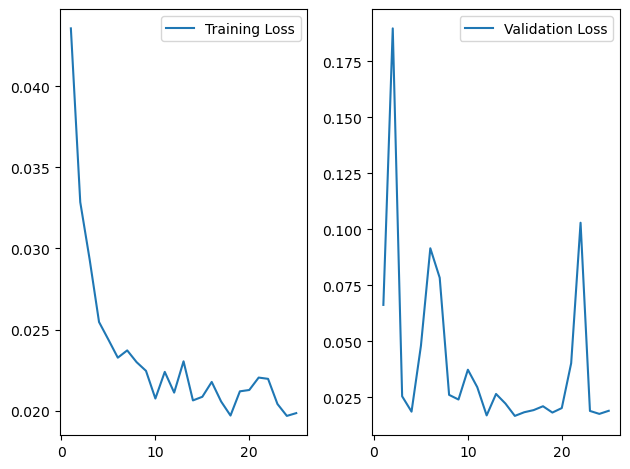

In [4]:
fig, ax = plt.subplots(nrows=1,ncols=2)
num_epochs = len(train_loss_record)
ax[0].plot(range(1, num_epochs + 1), train_loss_record, label='Training Loss')
ax[0].legend()
ax[1].plot(range(1, num_epochs + 1), validation_loss, label='Validation Loss')
ax[1].legend()
plt.tight_layout()

In [ ]:
gc.collect()
torch.cuda.empty_cache()
torch.cuda.set_per_process_memory_fraction(0.9999, 0)

In [6]:

# make gan and train
mwcnn_discriminator = Discriminator(n_feats=32, patch_size=IMAGESIZE).to(device)
VGG_loss = VGGPerceptualLoss(resize=False).to(device)
mwcnn_gan_trainer = GANTrainer(MWCNN_model, discriminator=mwcnn_discriminator, 
                               device=device, learning_rate=1e-3)

mwcnn_gan_loss_record, mwcnn_gan_validation_loss_record = mwcnn_gan_trainer.train(EPOCHS, trainloader, validationloader)
torch.save(MWCNN_model.state_dict(), "models/mwcnn_none_gan.pt")

Starting Training Process
Epoch: 001,  Train Loss:25.4046035,  Validation Loss:25.4866420,  Time training: 0h0m57s
Epoch: 002,  Train Loss:25.3923220,  Validation Loss:25.3686536,  Time training: 0h1m54s
Epoch: 003,  Train Loss:25.3749901,  Validation Loss:25.4347954,  Time training: 0h2m51s
Epoch: 004,  Train Loss:25.4190658,  Validation Loss:25.3756767,  Time training: 0h3m48s
Epoch: 005,  Train Loss:25.4127687,  Validation Loss:25.6319772,  Time training: 0h4m44s
Epoch 00006: reducing learning rate of group 0 to 8.5000e-04.
Epoch: 006,  Train Loss:25.4031931,  Validation Loss:25.3636138,  Time training: 0h5m41s
Epoch: 007,  Train Loss:25.3854864,  Validation Loss:25.3556155,  Time training: 0h6m38s
Epoch: 008,  Train Loss:25.3885637,  Validation Loss:25.3966324,  Time training: 0h7m35s
Epoch 00009: reducing learning rate of group 0 to 7.2250e-04.
Epoch: 009,  Train Loss:25.3924049,  Validation Loss:25.3988840,  Time training: 0h8m32s
Epoch: 010,  Train Loss:25.3722820,  Validation L

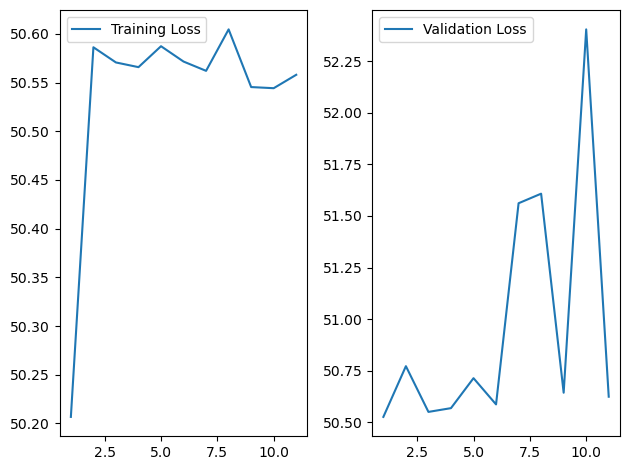

In [ ]:
fig, ax = plt.subplots(nrows=1,ncols=2)
num_epochs = len(mwcnn_gan_loss_record)
ax[0].plot(range(1, num_epochs + 1), mwcnn_gan_loss_record, label='Training Loss')
ax[0].legend()
ax[1].plot(range(1, num_epochs + 1), mwcnn_gan_validation_loss_record, label='Validation Loss')
ax[1].legend()
plt.tight_layout()